In [1]:
import numpy
import pandas
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

/home/sam/Github/365DaysOfData/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pandas.read_csv('data/cleaned_imdb.csv')

In [3]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch 1 Oz episode you ll...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,basically there s family little boy Jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter Matteis Love Time Money visually stunni...


#### okay basically, yesterday i tried glove embedding and tried sentiment analysis with logistic regression, today i am diving into advance architecture, i will use bert embeddings, and then i will create architecture like BERT finetuning,  Roberta implementation, DistilBert Implementation and even Prompt engineering

In [4]:
DEVICE = 0 if torch.cuda.is_available() else -1
print(f"Using CUDA: {torch.cuda.is_available()}")

Using CUDA: True


In [5]:
import random
import numpy as np

In [6]:
SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)  # it ensures that the random numbers generated on the GPU are also reproducible, which is important for consistent results across runs.

In [7]:
df.columns

Index(['review', 'sentiment', 'cleaned_review'], dtype='object')

In [8]:
TEXT_COL = 'cleaned_review'
LABEL_COL = 'sentiment'


In [9]:
df[TEXT_COL].head()

0    one reviewer mention watch 1 Oz episode you ll...
1    wonderful little production filming technique ...
2    think wonderful way spend time hot summer week...
3    basically there s family little boy Jake think...
4    petter Matteis Love Time Money visually stunni...
Name: cleaned_review, dtype: object

In [10]:
label2id = {'positive': 1, 'negative': 0}
id2label = {0: 'negative', 1: 'positive'}
df[LABEL_COL] = df[LABEL_COL].map(label2id)

In [11]:
df[LABEL_COL].map(id2label)

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49577    positive
49578    negative
49579    negative
49580    negative
49581    negative
Name: sentiment, Length: 49582, dtype: object

In [12]:
df['text'] = df[TEXT_COL].astype(str)

In [13]:
df.head()

,review,sentiment,cleaned_review,text
0,One of the other reviewers has mentioned that ...,1,one reviewer mention watch 1 Oz episode you ll...,one reviewer mention watch 1 Oz episode you ll...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,think wonderful way spend time hot summer week...,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,0,basically there s family little boy Jake think...,basically there s family little boy Jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter Matteis Love Time Money visually stunni...,petter Matteis Love Time Money visually stunni...


In [14]:
train_df, test_df = train_test_split(df[['cleaned_review', 'sentiment']], test_size=0.2, random_state=SEED, stratify=df['sentiment'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=SEED, stratify=train_df['sentiment'])
train_df = train_df.rename(columns={'cleaned_review': 'text', 'sentiment': 'label'})
test_df = test_df.rename(columns={'cleaned_review': 'text', 'sentiment': 'label'})
val_df = val_df.rename(columns={'cleaned_review': 'text', 'sentiment': 'label'})

In [15]:
train_df.size, test_df.size, val_df.size

(71396, 19834, 7934)

now we are going to make a dataloader

In [16]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Any
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score

In [17]:
class TorchTextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

def prepare_datasets(model_name: str, max_length: int = 128):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    def tokenize_texts(texts):
        return tokenizer(
            texts,
            truncation=True,
            padding=False,   # pad dynamically via DataCollator
            max_length=max_length
        )
    train_enc = tokenize_texts(train_df['text'].tolist())
    val_enc   = tokenize_texts(val_df['text'].tolist())
    test_enc  = tokenize_texts(test_df['text'].tolist())
    train_ds = TorchTextDataset(train_enc, train_df['label'].tolist())
    val_ds   = TorchTextDataset(val_enc, val_df['label'].tolist())
    test_ds  = TorchTextDataset(test_enc, test_df['label'].tolist())
    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return tokenizer, train_ds, val_ds, test_ds, collator

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [23]:
def train_and_eval(model_name, num_epochs=3, batch_size=8, lr=2e-5):
    tokenizer, train_ds, val_ds, test_ds, collator = prepare_datasets(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        id2label=id2label,
        label2id=label2id
    )

    args = TrainingArguments(
        output_dir=f"./checkpoints/{model_name.replace('/', '_')}",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        fp16=torch.cuda.is_available(),
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_result = trainer.evaluate(eval_dataset=test_ds)
    log_history = trainer.state.log_history

    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {
        "model_name": model_name,
        "test": eval_result,
        "logs": log_history
    }

def plot_learning_curves(log_history, title):
    hist = pandas.DataFrame(log_history)
    hist = hist.dropna(subset=['step'], how='any')
    plt.figure(figsize=(7,4))
    if 'loss' in hist.columns:
        sns.lineplot(data=hist[hist['loss'].notna()], x='step', y='loss', label='train_loss')
    if 'eval_loss' in hist.columns:
        sns.lineplot(data=hist[hist['eval_loss'].notna()], x='step', y='eval_loss', label='val_loss')
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()



=== Training bert-base-uncased ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4180/440385310.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.484500
1000,0.388800
1500,0.379200
2000,0.362100
2500,0.370900
3000,0.352100
3500,0.330500
4000,0.332300
4500,0.335100
5000,0.264200


Test metrics for bert-base-uncased: {'eval_loss': 0.535345733165741, 'eval_accuracy': 0.892507814863366, 'eval_f1': 0.8925069623290655, 'eval_runtime': 28.5347, 'eval_samples_per_second': 347.541, 'eval_steps_per_second': 43.456, 'epoch': 3.0}


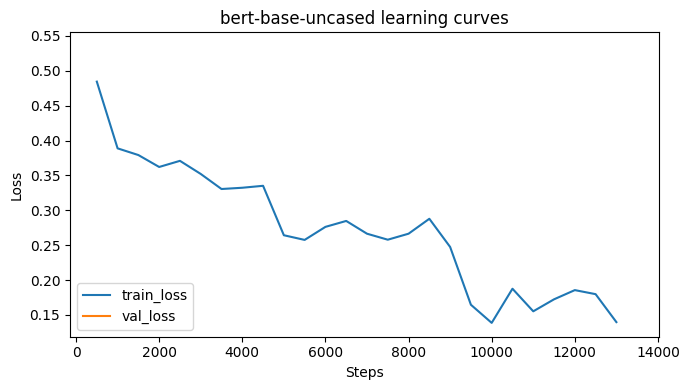

,model,test_accuracy,test_f1,test_loss
0,bert-base-uncased,0.892508,0.892507,0.535346


In [24]:
model_names = [
    "bert-base-uncased",
    # "roberta-base",
    # "distilbert-base-uncased",
]

results = []
for name in model_names:
    print(f"\n=== Training {name} ===")
    res = train_and_eval(name, num_epochs=3, batch_size=8, lr=2e-5)
    results.append(res)
    print(f"Test metrics for {name}: {res['test']}")
    plot_learning_curves(res['logs'], title=f"{name} learning curves")
    
# Summary table
summary = pandas.DataFrame(
    [
        {
            "model": r["model_name"],
            "test_accuracy": r["test"].get("eval_accuracy"),
            "test_f1": r["test"].get("eval_f1"),
            "test_loss": r["test"].get("eval_loss"),
        }
        for r in results
    ]
)
summary.sort_values("test_accuracy", ascending=False)